In [1]:
import numpy as np
np.random.seed(0)
np.seterr(divide='ignore')
import pandas as pd
import sys
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from models.STD import STD
from models.RDE import linear_sti
from models.ARNN import ARNN
from statsforecast.models import AutoETS, AutoTheta, AutoARIMA
from common.ops import hank, hankel_to_scalar
from common.losses import nrmse_loss
from common.Plot.plot import PlotMeta

## Linear system Demo
#### Generate data
The linear dynamic system is described by the following equation:

$$
\begin{align}
\dot{X}& = AX&&(\text{system transfer function}) \\
y &= \mathbf{b}^\top X&&(\text{observation equation})
\end{align}
$$

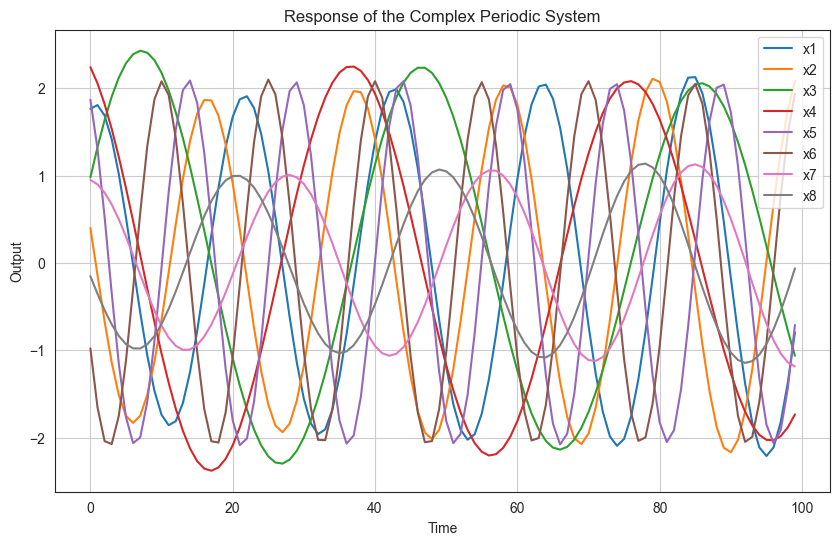

In [7]:
from scipy.signal import StateSpace, lsim
np.random.seed(0)
# Define system matrices
A = np.array([
    [0.1, 15, 0, 0, 0, 0, 0,0.1],
    [-15, 0.1, 0, 0, 0, 0, 0, 0.1],
    [0.1, 0, -0.1, 8, 0, 0, 0, 0],
    [0.1, 0, -8, -0.1, 0, 0, 0, 0],
    [0, 0, 0.1, 0, -0.01, 21, 0, 0],
    [0, 0, 0.1, 0, -21, -0.01, 0, 0],
    [0, 0, 0, 0, 0.1, 0, 0.1, 11],
    [0, 0, 0, 0, 0.1, 0, -11, 0.1]
])
B = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
])
C = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1],
    [0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0]
])
D = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
])

# Create state-space system
sys = StateSpace(A, B, C, D)

# Time sample points
t = np.linspace(0, 20, 1001)

# Input signal (zero input to observe the natural response)
u = np.zeros((len(t), 4))

# Initial state
x0 = np.random.randn(8)
eigenval, eigenvec = np.linalg.eig(A)
x0_coef = eigenvec.T @ x0
# Simulate the system
t, y, x = lsim(sys, U=u, T=t, X0=x0)

# Plot the states
plt.figure(figsize=(10, 6))
for i in range(x.shape[1]):
    plt.plot( x[:100, i], label=f'x{i+1}')
plt.title('Response of the Complex Periodic System')
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()
fre = np.exp(np.linalg.eigvals(A)*0.02)
per = 2*np.pi/fre.imag
# print(f'Eigenvalue of system:{fre}\nPeriods:{per}'  )


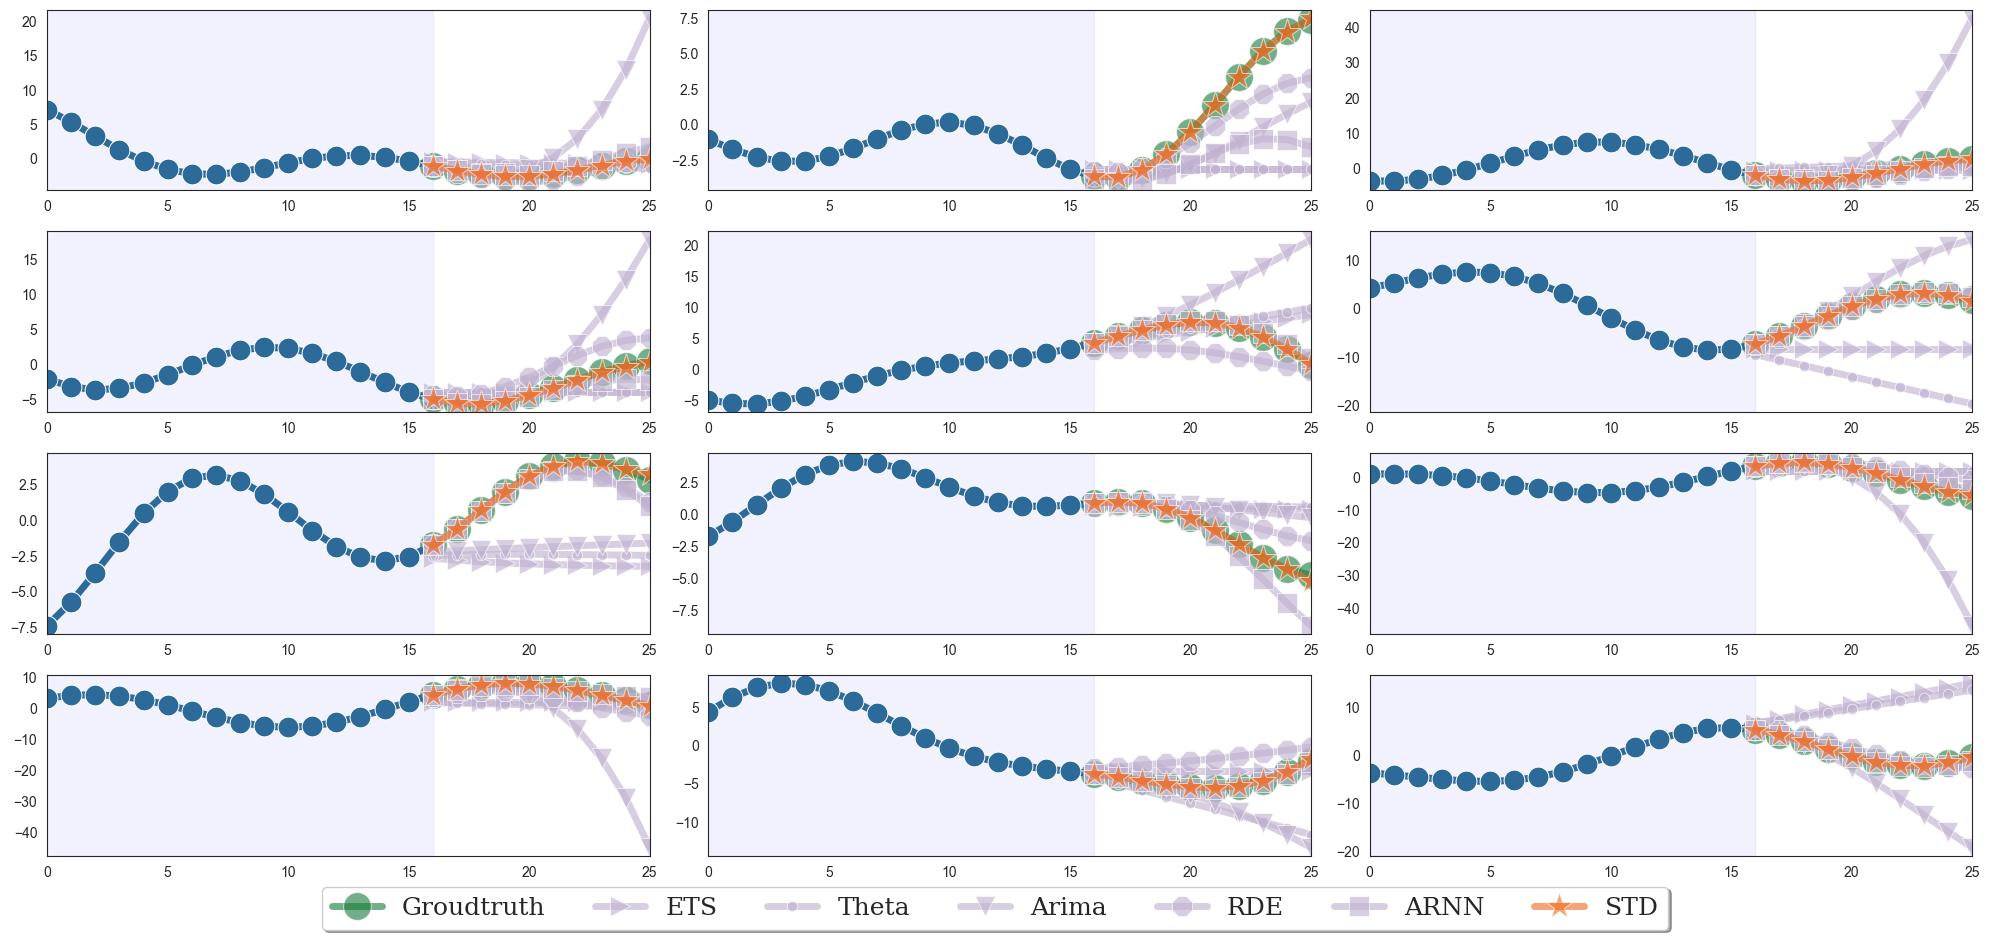

In [14]:
in_size = 16
out_size = 10
# model = STD(in_feature=8, in_size=in_size, k=out_size,lambda_1=0,lambda_2=0.,eps=1e-5).float()
fig, axes = plt.subplots(4, 3, figsize=(20, 10))
linewidth=5
markersize=15

for i in range(12):
        pres = []
        X = x[i*in_size:(i+1)*in_size,:]
        # X = x[i*in_size:(i+1)*in_size,:]+np.random.normal(0,0.01,(in_size,8))
        Y = np.concatenate(((X@[1, 1, 1, 1, 1, 1, 1, 1]).T,y[(i+1)*in_size:(i+1)*in_size+out_size,0].T),axis=0)
        test_y = Y[-out_size:]
        # mask, hankel_y = hank(Y,in_size,out_size,)
        
        ### STD
        for j in range(out_size):
            A_temp = np.linalg.lstsq(X[:-1-j,:],Y[j+1:in_size],rcond=None)[0]
            pres.append(A_temp.T@(X[-1,:].T))
            
        ### ETS
        ETS_pre = AutoETS().forecast(y=Y[:in_size],
                            X=X[:in_size,:],
                            h=out_size, fitted=True)['mean']
        ### Theta
        Theta_pre = AutoTheta().forecast(y=Y[:in_size],
                            X=X[:in_size,:],
                            h=out_size, fitted=True)['mean']
        ### Arima
        Arima_pre = AutoARIMA(biasadj=True).forecast(y=Y[:in_size],
                                                        h=out_size, fitted=True)['mean']
        ### RDE
        y_rde = np.zeros_like(Y)
        y_rde[:in_size] = Y[:in_size]
        Rde_pre, _ = linear_sti(8, out_size)(data=(X[:in_size,:].T, y_rde))
        ### ARNN
        ARNN_pre, _ = ARNN(x=X[:in_size,:].T, target=Y[:in_size], output_size=out_size).train()
        ARNN_pre = ARNN_pre[-out_size:].detach().numpy()

        loss_ = nrmse_loss(np.array(pres[-out_size:]),test_y)
        sns.lineplot(x=np.arange(in_size,in_size+out_size),y=test_y,alpha=0.618,markersize=markersize+5,
                        ax=axes[i//3,i%3],linewidth=linewidth,label='Groudtruth',marker='o',color=PlotMeta.color['gt'])
        sns.lineplot(x=np.arange(0,in_size+1),y=Y[:in_size+1],markersize=markersize,
                        ax=axes[i//3,i%3],linewidth=linewidth,marker='o',color=PlotMeta.color['tr'])
        sns.lineplot(x=np.arange(in_size,in_size+out_size),y=ETS_pre,alpha=0.618,linewidth=linewidth,markersize=markersize,
                        ax=axes[i//3,i%3],label='ETS',marker='>',color=PlotMeta.color['other'])
        sns.lineplot(x=np.arange(in_size,in_size+out_size),y=Theta_pre,alpha=0.618,linewidth=linewidth,markersize=markersize,
                        ax=axes[i//3,i%3],label='Theta',marker='.',color=PlotMeta.color['other'])
        sns.lineplot(x=np.arange(in_size,in_size+out_size),y=Arima_pre,alpha=0.618,linewidth=linewidth,markersize=markersize,
                        ax=axes[i//3,i%3],label='Arima',marker='v',color=PlotMeta.color['other'])
        sns.lineplot(x=np.arange(in_size,in_size+out_size),y=Rde_pre[-out_size:],alpha=0.618,linewidth=linewidth,markersize=markersize,
                        ax=axes[i//3,i%3],label='RDE',marker='8',color=PlotMeta.color['other'])
        sns.lineplot(x=np.arange(in_size,in_size+out_size),y=ARNN_pre[-out_size:],alpha=0.618,linewidth=linewidth,markersize=markersize,
                        ax=axes[i//3,i%3],label='ARNN',marker='s',color=PlotMeta.color['other'])
        sns.lineplot(x=np.arange(in_size,in_size+out_size),y=pres[-out_size:],alpha=0.618,linewidth=linewidth,
                        ax=axes[i//3,i%3],label=f'STD',marker='*',markersize=markersize+5,color=PlotMeta.color['std'])
        axes[i//3,i%3].set_xlim(xmin=0,xmax=in_size+out_size-1)
        axes[i//3,i%3].set_ylabel('')
        axes[i//3,i%3].get_legend().set_visible(False)
        axes[i//3,i%3].axvspan(0,in_size, color='blue', alpha=0.05)
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=7, prop={'size': 18, 'family': 'Serif'}, fancybox=True, shadow=True)
plt.tight_layout(w_pad=1,h_pad=1, rect=[0, 0.05, 1, 0.95])
plt.show()
fig.savefig(os.path.join(os.getcwd(),'..','png','linear.pdf'), format="pdf", bbox_inches="tight",transparent=True)


## Experiment for robustness of different prediction length

In [9]:
in_size = 16
out_size = 12
mean_loss = []
for k in range(1, out_size+1):
    loss = []
    for i in range(30):
        pres = []
        X = x[i*in_size:(i+1)*in_size,:]
        Y = np.concatenate(((X@[1, 1, 1, 1, 1, 1, 1, 1]).T,y[(i+1)*in_size:(i+1)*in_size+k,0].T),axis=0)
        test_y = Y[-k:]
        
        ### STD
        for j in range(k):
            A_temp = np.linalg.lstsq(X[:-1-j,:],Y[j+1:in_size],rcond=None)[0]
            pres.append(A_temp.T@(X[-1,:].T))
            
        ### ETS
        ETS_pre = AutoETS().forecast(y=Y[:in_size],
                            X=X[:in_size,:],
                            h=k, fitted=True)['mean']
        ### Theta
        Theta_pre = AutoTheta().forecast(y=Y[:in_size],
                            X=X[:in_size,:],
                            h=k, fitted=True)['mean']
        ### Arima
        Arima_pre = AutoARIMA(biasadj=True).forecast(y=Y[:in_size],
                                                        h=k, fitted=True)['mean']
        ### RDE
        y_rde = np.zeros_like(Y)
        y_rde[:in_size] = Y[:in_size]
        Rde_pre, _ = linear_sti(8, k)(data=(X[:in_size,:].T, y_rde))
        ### ARNN
        ARNN_pre, _ = ARNN(x=X[:in_size,:].T, target=Y[:in_size], output_size=k).train()
        ARNN_pre = ARNN_pre[-k:].detach().numpy()

        std_loss = nrmse_loss(np.array(pres[-k:]),test_y)
        ets_loss = nrmse_loss(ETS_pre[-k:],test_y)
        theta_loss = nrmse_loss(Theta_pre[-k:],test_y)   
        arima_loss = nrmse_loss(Arima_pre[-k:],test_y)
        rde_loss = nrmse_loss(Rde_pre[-k:],test_y)
        arnn_loss = nrmse_loss(ARNN_pre[-k:],test_y)
        loss.append([ets_loss,theta_loss,arima_loss,rde_loss,arnn_loss,std_loss])
    mean_loss.append(np.mean(loss,axis=0))
    

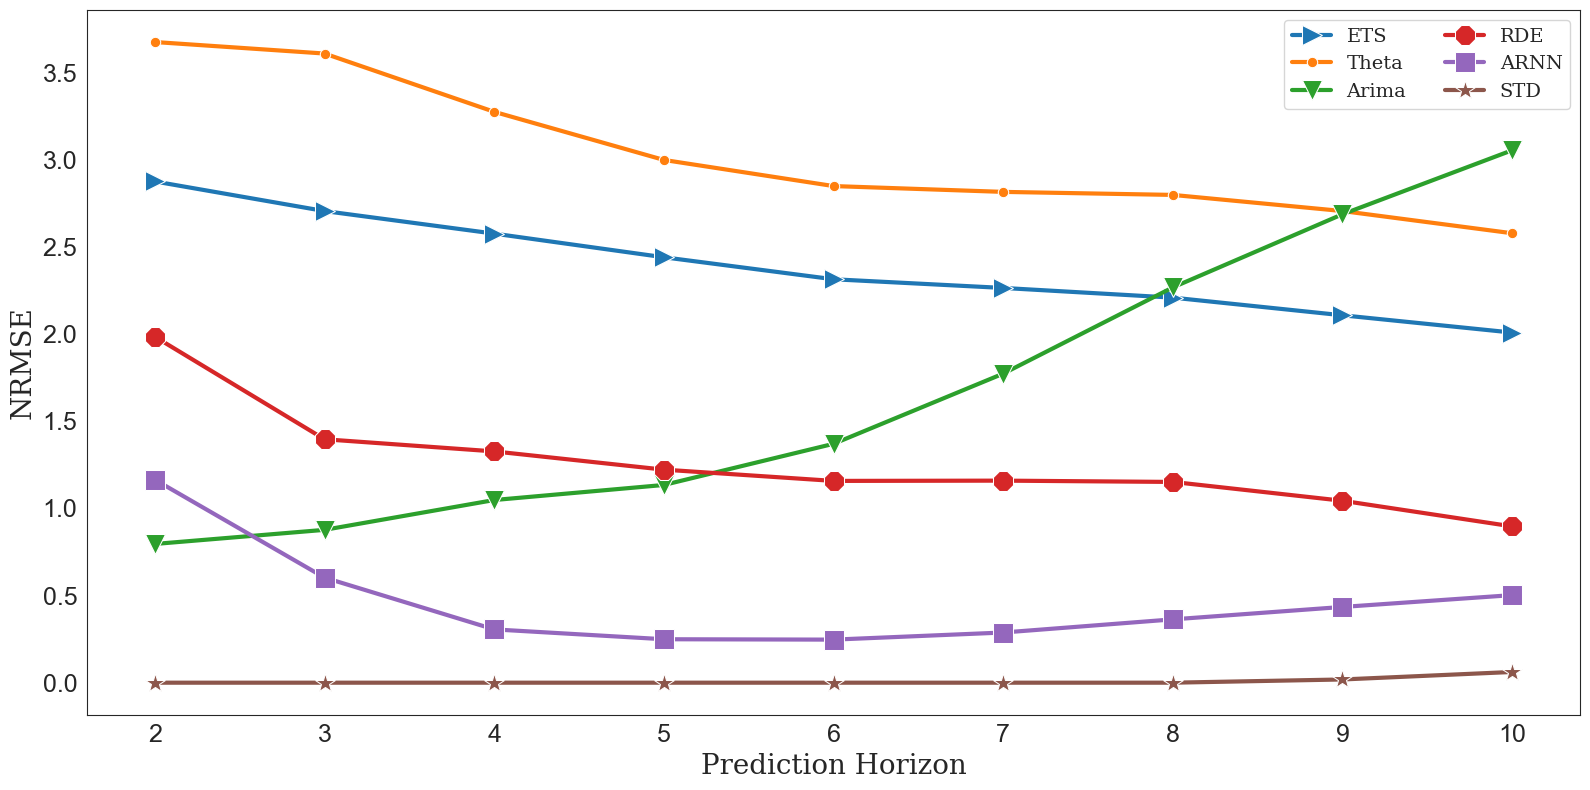

In [13]:
labels = ['ETS', 'Theta', 'Arima', 'RDE', 'ARNN','STD']
markers = ['>', '.', 'v', '8','s', '*']
for i in range(6):
    sns.lineplot(x=np.arange(1, 10+1),y= np.array(mean_loss)[:10,i],marker=markers[i],linewidth=3,markersize=markersize,label=labels[i])

plt.xlabel('Prediction Horizon',fontdict={'size': 20, 'family': 'Serif'})
plt.ylabel('NRMSE',fontdict={'size': 20, 'family': 'Serif'})
plt.xticks(np.arange(2, 10+1),fontsize=18)
plt.yticks(fontsize=18)
plt.legend(ncol=2,prop={'size': 14, 'family': 'Serif'})
fig = plt.gcf()
fig.set_size_inches(16, 8)
# fig.legend(['ETS', 'Theta', 'Arima', 'RDE', 'ARNN','STD'], prop={'size': 20, 'family': 'Serif'})
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(os.getcwd(),'..','png','linear_out.pdf'), format="pdf", bbox_inches="tight",transparent=True)